# Import Data

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize


from sklearn.decomposition import PCA

In [2]:
import seaborn as sns
sns.set()

In [3]:
def create_confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None, display_labels=None,
                           include_values=True, xticks_rotation='horizontal', values_format=None,
                           cmap='viridis', ax=None, colorbar=True):
    
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_pred)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [4]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [5]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1

    return TP/(TP+FP)

In [6]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [7]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.4f} - {:0.4}]".format(name, i,
        confidence_lower, confidence_upper))

In [8]:
def my_classification_report(y_test_np, y_pred):

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    spec_arr = []
    ppv_arr = [] ##
    npv_arr = [] ##
    rec_arr = []
    acc_arr = []

    print("Specificities")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TN += TN
        tot_FP += FP
        spec_arr.append(TN/(TN+FP))
        print(group, spec_arr[group])

    print("Macro Avg : " + str(np.array(spec_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("PPV/Precision") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TP += TP
        tot_FP += FP
        ppv_arr.append(TP/(TP+FP))
        print(group, ppv_arr[group])
    
    print("Macro Avg : " + str(np.array(ppv_arr).mean()))
    prec_for_mic_f1 = tot_TP / (tot_TP + tot_FP)
    print("Micro Avg : " + str(prec_for_mic_f1), '\n')

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("NPV") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TN += TN
        tot_FN += FN
        npv_arr.append(TN/(TN+FN))
        print(group, npv_arr[group])
    
    print("Macro Avg : " + str(np.array(npv_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN)), '\n') 
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Recall") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TP += TP
        tot_FN += FN
        rec_arr.append(TP/(TP+FN))
        print(group, rec_arr[group])
    
    print("Macro Avg : " + str(np.array(rec_arr).mean()))
    rec_for_mic_f1 = tot_TP / (tot_TP + tot_FN)
    print("Micro Avg : " + str(rec_for_mic_f1), '\n')
    
    print("F1 Score") ##
    for group in range(3):
        print(group, 2 * (rec_arr[group] * ppv_arr[group]) / (rec_arr[group] + ppv_arr[group]))
    print("Macro Avg : " + str(2 * (np.array(rec_arr).mean() * np.array(ppv_arr).mean()) 
                               / (np.array(rec_arr).mean() + np.array(ppv_arr).mean())))
    print("Micro Avg : " + str(2 * (prec_for_mic_f1 * rec_for_mic_f1)/ (prec_for_mic_f1 + rec_for_mic_f1)), '\n')
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0   
    
    print("Accuracy:")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        
        tot_TP += TP
        tot_TN += TN
        tot_FP += FP
        tot_FN += FN
        
        acc_arr.append((TP + TN)/(TP + TN + FP + FN))
        print(group, acc_arr[group])
        #print("TP:" + str(TP))
        #print("TN:" + str(TN))
        #print("FP:" + str(FP))
        #print("FN:" + str(FN))
        
        #print(TP + TN)
        #print(TP + TN + FP + FN, '\n')
        
    #print("Total TP:" + str(tot_TP))
    #print("Total TN:" + str(tot_TN))
    #print("Total FP:" + str(tot_FP))
    #print("Total FN:" + str(tot_FN), '\n')

    print("Macro Avg : " + str(np.array(acc_arr).mean()))
    print("Micro Avg : " + str((tot_TP + tot_TN)/(tot_TP + tot_TN + tot_FP + tot_FN)), '\n') ##

In [9]:
#df = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/binary/wnt_rest.xlsx")
df = pd.read_excel("/Users/samwwong/Desktop/tumor-classification/molec_binary_seq/mb_t1_t2_4way.xlsx")

# RF1 -> NN2

In [10]:
df

,molecular,molec_id,sex,dx_date,age,alive,os,pfs,seg_id,t1_log-sigma-1-mm-3D_firstorder_10Percentile,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,shh,BO_PF-MB_F_0007,F,2000-05-05 00:00:00,79.0,NaN,33,NaN,BO_PF-MB_F_0007_,-14.446979,...,1.973686,0.000808,1027.170040,0.297042,0.562429,1220.949377,0.000601,7.518529,0.134000,5335.217376
1,wnt,BO_PF-MB_F_0008,F,2006-01-05 00:00:00,90.0,Alive,30,NaN,BO_PF-MB_F_0008_,-11.965873,...,0.243711,0.005756,344.000989,0.340258,0.604408,481.129194,0.004316,7.318544,0.252624,209.948818
2,wnt,BO_PF-MB_F_0010,F,2000-08-16 00:00:00,76.0,Alive,92,NaN,BO_PF-MB_F_0010_,-15.311574,...,0.049205,0.000786,4051.276393,0.385322,0.644380,1826.940136,0.000552,8.163314,0.350257,66.167310
3,type4,BO_PF-MB_F_0015,F,2001-01-25 00:00:00,121.0,Alive,84,NaN,BO_PF-MB_F_0015_,-6.059545,...,3.112323,0.003300,481.319732,0.321953,0.586631,463.640209,0.002341,7.438314,0.129236,2106.125227
4,shh,BO_PF-MB_F_0017,F,2004-06-06 00:00:00,27.0,Alive,44,NaN,BO_PF-MB_F_0017_,-25.161749,...,0.094180,0.001028,1305.932045,0.382523,0.642779,1897.521463,0.000611,7.748172,0.291049,174.711614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,shh,UT_PF-MB_M_0041,M,2017-09-09 00:00:00,22.0,NaN,25,NaN,UT_PF-MB_M_0041_,-27.907258,...,1.211945,0.000565,3764.525654,0.387856,0.646073,2209.516014,0.000413,7.867412,0.257590,2245.267377
217,wnt,UT_PF-MB_M_0046,M,2015-01-24 00:00:00,172.0,Alive,39,NaN,UT_PF-MB_M_0046_,-16.559532,...,2.395014,0.001504,1891.628493,0.324298,0.589271,825.808563,0.001061,7.623581,0.181374,2622.388341
218,type4,UT_PF-MB_M_0047,M,2014-07-31 00:00:00,74.0,Alive,66,NaN,UT_PF-MB_M_0047_,-34.380056,...,0.624603,0.001676,1620.801636,0.323449,0.587494,651.778314,0.001052,7.619742,0.242852,478.635109
219,shh,UT_PF-MB_M_0048,M,2012-09-06 00:00:00,14.0,Alive,88,NaN,UT_PF-MB_M_0048_,-32.209457,...,2.016422,0.000795,3300.903006,0.325372,0.588549,1307.124424,0.000533,7.851386,0.205148,2879.261041


In [11]:
first_target = df["molecular"]

In [12]:
first_target.value_counts()

shh      83
type4    64
type3    48
wnt      26
Name: molecular, dtype: int64

In [13]:
reduced_features = pd.read_excel("/Users/samwwong/Desktop/tumor-classification/molec_binary_seq/binary_reduced.xlsx")

In [14]:
reduced_features_list = reduced_features.loc[reduced_features['wnt_rest'].isnull() == False, ['wnt_rest']].values.tolist()
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [15]:
first_target = first_target.map(dict(wnt = 0, shh = 1, type3 = 1, type4 = 1))

In [16]:
first_features = df[reduced_features_list]

In [17]:
sex_binarized = first_features['sex'].map(dict(M = 1, F = 0)).to_numpy()

first_features['sex'] = sex_binarized

<ipython-input-17-7abfed4242db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_features['sex'] = sex_binarized


In [18]:
first_features.head()

,sex,age,t1_log-sigma-1-mm-3D_glcm_Correlation,t1_log-sigma-1-mm-3D_glcm_InverseVariance,t1_log-sigma-1-mm-3D_glcm_MCC,t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniformityNormalized,t1_log-sigma-5-mm-3D_firstorder_Skewness,t1_wavelet-HHL_firstorder_Median,t1_wavelet-HLH_firstorder_Skewness,...,t2_log-sigma-5-mm-3D_firstorder_90Percentile,t2_log-sigma-5-mm-3D_glrlm_RunEntropy,t2_wavelet-HHL_glrlm_LongRunHighGrayLevelEmphasis,t2_wavelet-LHL_glcm_InverseVariance,t1_log-sigma-5-mm-3D_firstorder_Median,t1_wavelet-HHH_glcm_ClusterShade,t2_log-sigma-3-mm-3D_firstorder_Median,t2_wavelet-LHL_firstorder_Energy,t2_wavelet-LHH_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-HHL_firstorder_Energy
0,0,79.0,0.505918,0.456103,0.562873,0.009914,0.151307,0.745832,-0.008154,0.027467,...,-3.319491,5.205622,381.588056,0.413472,-21.023060,0.002760,-9.091005,7.855152e+06,0.775000,2.039729e+06
1,0,90.0,0.432892,0.432303,0.475984,0.102841,0.375000,-0.423881,-0.033418,0.127864,...,-2.592589,4.949568,188.395559,0.375094,-13.636353,0.011874,-23.093743,1.776711e+06,0.625000,9.030103e+05
2,0,76.0,0.507732,0.467495,0.534334,0.003729,0.143779,0.266144,-0.174364,0.068410,...,-8.626585,5.409242,210.395917,0.309880,-16.443489,0.000162,-15.260113,2.753361e+07,0.785714,5.791610e+06
3,0,121.0,0.469566,0.359673,0.506549,0.031691,0.314129,0.393157,0.092495,-0.137343,...,-13.716932,4.941416,100.589683,0.456882,1.676658,0.001026,-16.307477,1.583997e+06,0.625000,3.200592e+05
4,0,27.0,0.577000,0.457465,0.591460,0.005969,0.099021,0.156855,-0.127051,0.036008,...,4.093615,5.118160,312.123409,0.325784,-39.815252,0.000574,-2.067522,8.533643e+06,0.358333,4.353275e+06


In [19]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(first_features, first_target, 
                                                   test_size = 0.25, random_state = 42)

In [20]:
y_train_1.value_counts()

1    147
0     18
Name: molecular, dtype: int64

In [21]:
y_test_1.value_counts()

1    48
0     8
Name: molecular, dtype: int64

In [22]:
first_X = pd.concat([X_train_1, y_train_1], axis = 1)
first_X_0 = first_X[first_X['molecular'] == 0]
first_X_1 = first_X[first_X['molecular'] == 1]

In [23]:
upsampled_0 = resample(first_X_0, replace = True, n_samples = len(first_X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, first_X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [24]:
X_train_1 = upsampled.iloc[:, :-1]
y_train_1 = upsampled.iloc[:, -1]

In [25]:
y_train_1.value_counts()

1    147
0    147
Name: molecular, dtype: int64

In [26]:
names = X_train_1.columns
first_scaler = preprocessing.StandardScaler()

# RF1: wnt vs rest1

In [27]:
X_train_1 = first_scaler.fit_transform(X_train_1)
X_train_1 = pd.DataFrame(X_train_1, columns = names)

X_test_1 = first_scaler.transform(X_test_1)
X_test_1 = pd.DataFrame(X_test_1, columns = names)

In [28]:
rf_seq_1_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_seq_1_grid = GridSearchCV(estimator=rf_seq_1_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [29]:
rf_seq_1_grid.fit(X_train_1, y_train_1)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [30]:
print(rf_seq_1_grid.best_params_)

{'max_depth': 4, 'n_estimators': 100}


In [31]:
rf_seq_1_model = RandomForestClassifier(max_depth = 4, n_estimators = 100, random_state = 42)
rf_seq_1_model.fit(X_train_1, y_train_1)
y_pred_1 = rf_seq_1_model.predict(X_test_1)

In [32]:
np.array(y_test_1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [33]:
y_pred_1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
print("Accuracy Score: " + str(accuracy_score(y_test_1, y_pred_1)))
print("Specificity Score: " + str(specificity_score(y_test_1.to_numpy(), y_pred_1)))
print("Precision: " + str(precision_score(y_test_1, y_pred_1)))
print("Recall: " + str(recall_score(y_test_1, y_pred_1)))
print("F1 Score: " + str(f1_score(y_test_1, y_pred_1)))

#print("PPV Score: " + str(positive_pv_score(y_test_1.to_numpy(), y_pred_1)))
#print("NPV Score: " + str(negative_pv_score(y_test_1.to_numpy(), y_pred_1)))

Accuracy Score: 0.875
Specificity Score: 0.25
Precision: 0.8867924528301887
Recall: 0.9791666666666666
F1 Score: 0.9306930693069307


# NN2 - [shh vs rest2] decomposed from rest1 

In [35]:
second_target = df["molecular"]

In [36]:
second_target.value_counts()

shh      83
type4    64
type3    48
wnt      26
Name: molecular, dtype: int64

In [37]:
second_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)

In [38]:
second_target = second_target.map(dict(shh = 0, wnt = -1, type3 = 1, type4 = 1))
second_target = second_target[second_target != -1]
second_features = second_features.iloc[second_target.index]

In [39]:
second_target.value_counts()

1    112
0     83
Name: molecular, dtype: int64

In [40]:
second_target = second_target.reset_index(drop = True)
second_features = second_features.reset_index(drop = True)

In [41]:
second_reduced_features_list = reduced_features.loc[reduced_features['2ndstage_shh_rest'].isnull() == False, ['2ndstage_shh_rest']].values.tolist()

In [42]:
second_reduced_features_list = [item for sublist in second_reduced_features_list for item in sublist]

In [43]:
second_features = second_features[second_reduced_features_list]

In [44]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(second_features, second_target, 
                                                    test_size = 0.25, random_state = 42)

In [45]:
second_X = pd.concat([X_train_2, y_train_2], axis = 1)
second_X_0 = second_X[second_X['molecular'] == 0]
second_X_1 = second_X[second_X['molecular'] == 1]

In [46]:
second_upsampled_0 = resample(second_X_0, replace = True, n_samples = len(second_X_1), random_state = 42)
second_upsampled = pd.concat([second_upsampled_0, second_X_1])
second_upsampled = second_upsampled.sample(frac = 1, random_state = 42)

In [47]:
X_train_2 = second_upsampled.iloc[:, :-1]
y_train_2 = second_upsampled.iloc[:, -1]

In [48]:
second_names = X_train_2.columns
second_scaler = preprocessing.StandardScaler()

In [49]:
X_train_2 = second_scaler.fit_transform(X_train_2)
X_train_2 = pd.DataFrame(X_train_2, columns = second_names)

In [50]:
X_test_2 = second_scaler.transform(X_test_2)
X_test_2 = pd.DataFrame(X_test_2, columns = second_names)

In [51]:
nn_seq_2_model = MLPClassifier(hidden_layer_sizes = (50, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)

In [52]:
nn_seq_2_model.fit(X_train_2, y_train_2)
y_pred_2 = nn_seq_2_model.predict(X_test_2)

In [53]:
accuracy_score(y_test_2, y_pred_2)

0.673469387755102

In [54]:
print("Accuracy Score: " + str(accuracy_score(y_test_2, y_pred_2)))
print("Specificity Score: " + str(specificity_score(y_test_2.to_numpy(), y_pred_2)))
print("Precision: " + str(precision_score(y_test_2, y_pred_2)))
print("Recall: " + str(recall_score(y_test_2, y_pred_2)))
print("F1 Score: " + str(f1_score(y_test_2, y_pred_2)))

print("PPV Score: " + str(positive_pv_score(y_test_2.to_numpy(), y_pred_2)))
print("NPV Score: " + str(negative_pv_score(y_test_2.to_numpy(), y_pred_2)))

Accuracy Score: 0.673469387755102
Specificity Score: 0.5909090909090909
Precision: 0.6896551724137931
Recall: 0.7407407407407407
F1 Score: 0.7142857142857143
PPV Score: 0.6896551724137931
NPV Score: 0.65


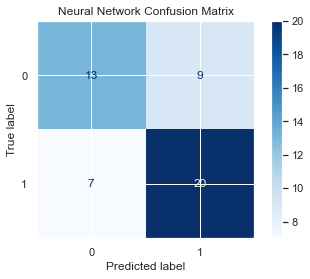

In [55]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

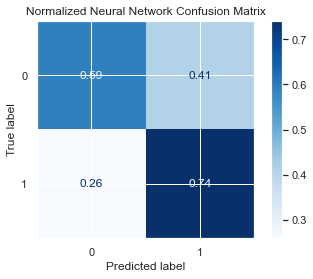

In [56]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

# Testing

In [57]:
test_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1) 
test_target = df["molecular"]

In [58]:
test_target = test_target.map(dict(wnt = 0, shh = 1, type3 = 2, type4 = 2))

In [59]:
X_train, X_test, y_train, y_test = train_test_split(test_features, test_target, 
                                                    test_size = 0.25, random_state = 42)

In [60]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [61]:
sex_binarized = X_test['sex'].map(dict(M = 1, F = 0)).to_numpy()

X_test['sex'] = sex_binarized

In [62]:
X_test_reduced = X_test[reduced_features_list]

In [63]:
names = X_test_reduced.columns
X_test_for_first = first_scaler.transform(X_test_reduced)
X_test_for_first = pd.DataFrame(X_test_for_first, columns = names)

In [64]:
y_preds_after_first = rf_seq_1_model.predict(X_test_for_first)

In [65]:
y_preds_after_first

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [66]:
wnt_indices = np.where(y_preds_after_first == 0)
other_indices = np.where(y_preds_after_first != 0)

In [67]:
wnt_preds = y_preds_after_first[wnt_indices]
y_test_for_wnt = np.array(y_test)[wnt_indices]

In [68]:
X_test_after_first_model = X_test.iloc[other_indices].reset_index(drop = True)
y_test_after_first_model = y_test.iloc[other_indices].reset_index(drop = True)

In [69]:
other_indices

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55]),)

In [70]:
np.array(y_test)

array([2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0,
       1, 1, 0, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 1,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0])

In [71]:
np.array(y_test_after_first_model)

array([2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1,
       1, 2, 1, 2, 2, 1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 0])

In [72]:
X_test_after_first_model = X_test_after_first_model[second_reduced_features_list]

In [73]:
X_test_after_first_model = second_scaler.transform(X_test_after_first_model)

In [74]:
y_test_after_first_model = np.array(y_test_after_first_model)
y_test_after_first_model[y_test_after_first_model == 0] = -1
y_test_after_first_model[y_test_after_first_model == 1] = 0
y_test_after_first_model[y_test_after_first_model == 2] = 1

In [75]:
y_preds_after_second = nn_seq_2_model.predict(X_test_after_first_model)

In [76]:
accuracy_score(y_test_after_first_model, y_preds_after_second)

0.7924528301886793

In [77]:
y_preds_after_second[y_preds_after_second == 1] = 2
y_preds_after_second[y_preds_after_second == 0] = 1

In [78]:
y_test_after_first_model

array([ 1,  1,  0,  1,  0,  0,  1,  1,  1, -1,  0,  0,  1,  1,  1,  0,  1,
        1,  1,  1, -1,  0,  0,  1,  0,  1,  1,  0, -1,  0,  1,  1,  0,  1,
        1,  1,  1,  0, -1, -1,  0,  1,  1,  1,  1,  0,  1,  0,  1,  1,  1,
        1, -1])

In [79]:
y_test_after_first_model[y_test_after_first_model == 1] = 2
y_test_after_first_model[y_test_after_first_model == 0] = 1
y_test_after_first_model[y_test_after_first_model == -1] = 0

In [80]:
y_preds_overall = np.concatenate([y_preds_after_second, wnt_preds])
y_test_overall = np.concatenate([y_test_after_first_model, y_test_for_wnt])

In [81]:
accuracy_score(y_test_overall, y_preds_overall)

0.7857142857142857

In [82]:
sns.reset_orig()

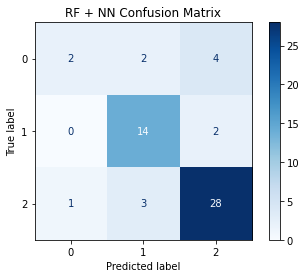

In [83]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues)
plt.title('RF + NN Confusion Matrix')
plt.show(matrix)
plt.show()

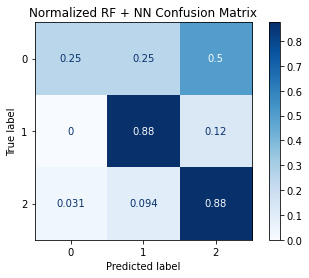

In [84]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues, normalize = 'true')
plt.title('Normalized RF + NN Confusion Matrix')
plt.show(matrix)
plt.show()

In [85]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_overall, y_preds_overall)

Specificities
0 0.9791666666666666
1 0.875
2 0.75
Macro Avg : 0.8680555555555555
Micro Avg : 0.8928571428571429 

PPV/Precision
0 0.6666666666666666
1 0.7368421052631579
2 0.8235294117647058
Macro Avg : 0.74234606123151
Micro Avg : 0.7857142857142857 

NPV
0 0.8867924528301887
1 0.9459459459459459
2 0.8181818181818182
Macro Avg : 0.8836400723193177
Micro Avg : 0.8928571428571429 

Recall
0 0.25
1 0.875
2 0.875
Macro Avg : 0.6666666666666666
Micro Avg : 0.7857142857142857 

F1 Score
0 0.36363636363636365
1 0.7999999999999999
2 0.8484848484848485
Macro Avg : 0.7024739583333333
Micro Avg : 0.7857142857142857 

Accuracy:
0 0.875
1 0.875
2 0.8214285714285714
Macro Avg : 0.8571428571428571
Micro Avg : 0.8571428571428571 



In [86]:
y_test_bin = label_binarize(y_test_overall, classes = [0, 1, 2])
y_pred_bin = label_binarize(y_preds_overall, classes = [0, 1, 2])

In [87]:
n_classes = 3

n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test_overall), len(y_test_overall))
    if len(np.unique(y_test_overall[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    for i in range(n_classes):
        one_acc.append(accuracy_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_spec.append(specificity_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_prec.append(precision_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_rec.append(recall_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_f_one.append(f1_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##

    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ZeroDivisionError: division by zero

In [88]:
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the Accuracy score for class 0: [0.8214 - 0.9286]
95% Confidence interval for the Accuracy score for class 1: [0.7857 - 0.9107]
95% Confidence interval for the Accuracy score for class 2: [0.7143 - 0.8571]
95% Confidence interval for the Specificity score for class 0: [0.9600 - 1.0]
95% Confidence interval for the Specificity score for class 1: [0.7727 - 0.9189]
95% Confidence interval for the Specificity score for class 2: [0.6087 - 0.8462]
95% Confidence interval for the Precision score for class 0: [0.5000 - 1.0]
95% Confidence interval for the Precision score for class 1: [0.4615 - 0.88]
95% Confidence interval for the Precision score for class 2: [0.7500 - 0.8788]
95% Confidence interval for the Recall score for class 0: [0.0909 - 0.5]
95% Confidence interval for the Recall score for class 1: [0.6875 - 0.9444]
95% Confidence interval for the Recall score for class 2: [0.7368 - 0.9]
95% Confidence interval for the F1 score for class 0: [0.1667 - 0.5455]


# Classification Results

In [89]:
metadata_df = df['molecular']
target_for_table = df['molecular']

In [90]:
features_for_table = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
target_for_table = target_for_table.map(dict(wnt = 0, shh = 1, type3 = 2, type4 = 2))

In [91]:
#only used for metadata for which is train and which is test
X_train_for_table, X_test_for_table, _, _ = train_test_split(features_for_table, target_for_table, 
                                                    test_size = 0.25, random_state = 42)

In [92]:
X_train_for_table['Set'] = 'training'
X_test_for_table['Set'] = 'test'

<ipython-input-92-e808b9f961f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_for_table['Set'] = 'training'
<ipython-input-92-e808b9f961f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_for_table['Set'] = 'test'


In [93]:
X_for_table = pd.concat([X_train_for_table, X_test_for_table])
X_for_table = pd.merge(metadata_df, X_for_table, left_index = True, right_index = True)

In [94]:
final_df = X_for_table[['molecular', 'Set']]
features_for_table = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
target_for_table = X_for_table['molecular']
target_for_table = target_for_table.map(dict(wnt = 0, shh = 1, type3 = 2, type4 = 2))

In [95]:
X_table_reduced = features_for_table[reduced_features_list]

In [96]:
sex_binarized = X_table_reduced['sex'].map(dict(M = 1, F = 0)).to_numpy()

X_table_reduced['sex'] = sex_binarized

<ipython-input-96-ad9946e9319b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_table_reduced['sex'] = sex_binarized


In [97]:
names = X_table_reduced.columns
X_table_for_first = first_scaler.transform(X_table_reduced)
X_table_for_first = pd.DataFrame(X_table_for_first, columns = names)

In [98]:
y_probs_after_first_table = rf_seq_1_model.predict_proba(X_table_for_first)

In [99]:
y_probs_after_first_table

array([[0.18635416, 0.81364584],
       [0.86927546, 0.13072454],
       [0.92032167, 0.07967833],
       [0.05134236, 0.94865764],
       [0.14888675, 0.85111325],
       [0.90489218, 0.09510782],
       [0.04251487, 0.95748513],
       [0.07635415, 0.92364585],
       [0.04185463, 0.95814537],
       [0.21215308, 0.78784692],
       [0.17318971, 0.82681029],
       [0.14755753, 0.85244247],
       [0.269277  , 0.730723  ],
       [0.34823887, 0.65176113],
       [0.01446168, 0.98553832],
       [0.15029549, 0.84970451],
       [0.07874007, 0.92125993],
       [0.01580588, 0.98419412],
       [0.04891545, 0.95108455],
       [0.31044361, 0.68955639],
       [0.23698444, 0.76301556],
       [0.2858363 , 0.7141637 ],
       [0.02599236, 0.97400764],
       [0.16946639, 0.83053361],
       [0.1018453 , 0.8981547 ],
       [0.10048523, 0.89951477],
       [0.13252402, 0.86747598],
       [0.17330832, 0.82669168],
       [0.05230226, 0.94769774],
       [0.23410147, 0.76589853],
       [0.

In [100]:
rf_1_table = pd.DataFrame(y_probs_after_first_table, columns = ['RF1 WNT Prob','RF1 Non-WNT Prob'])

In [101]:
final_df['RF1 WNT Prob'] = rf_1_table['RF1 WNT Prob']
final_df['RF1 Non-WNT Prob'] = rf_1_table['RF1 Non-WNT Prob']

<ipython-input-101-38e2da87a374>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['RF1 WNT Prob'] = rf_1_table['RF1 WNT Prob']
<ipython-input-101-38e2da87a374>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['RF1 Non-WNT Prob'] = rf_1_table['RF1 Non-WNT Prob']


In [102]:
y_preds_after_first_table = rf_seq_1_model.predict(X_table_for_first)
wnt_table_indices = np.where(y_preds_after_first_table == 0)
other_table_indices = np.where(y_preds_after_first_table != 0)

In [103]:
y_table_for_wnt = np.array(y_preds_after_first_table)[wnt_table_indices]
X_table_after_first_model = features_for_table.iloc[other_table_indices]
X_table_after_first_model = X_table_after_first_model[second_reduced_features_list]
X_table_after_first_model_arr = second_scaler.transform(X_table_after_first_model)

In [104]:
y_probs_after_second_table = nn_seq_2_model.predict_proba(X_table_after_first_model_arr)
y_preds_after_second_table = nn_seq_2_model.predict(X_table_after_first_model_arr)

In [105]:
nn_2_table = pd.DataFrame(y_probs_after_second_table, columns = ['NN2 SHH Prob','NN2 Type 3/4 Prob'])

In [106]:
X_table_after_first_model['NN2 SHH Prob'] = np.array(nn_2_table['NN2 SHH Prob'])
X_table_after_first_model['NN2 Type 3/4 Prob'] = np.array(nn_2_table['NN2 Type 3/4 Prob'])

In [107]:
X_table_after_first_model = X_table_after_first_model[['NN2 SHH Prob', 'NN2 Type 3/4 Prob']]

In [108]:
final_df = final_df.merge(X_table_after_first_model, how='left', left_index=True, right_index=True)

In [109]:
def f(row):
    if row['RF1 Non-WNT Prob'] < row['RF1 WNT Prob']:
        val = 'wnt'
    else:
        if row['NN2 SHH Prob'] > row['NN2 Type 3/4 Prob']:
            val = 'shh'
        else:
            val = 'type 3/4'
    return val

In [110]:
final_df['molec_id'] = df['molec_id']

In [111]:
final_df['Pred Path'] = final_df.apply(f, axis = 1)

In [112]:
final_df

,molecular,Set,RF1 WNT Prob,RF1 Non-WNT Prob,NN2 SHH Prob,NN2 Type 3/4 Prob,molec_id,Pred Path
0,shh,training,0.186354,0.813646,9.998265e-01,0.000173,BO_PF-MB_F_0007,shh
1,wnt,training,0.869275,0.130725,NaN,NaN,BO_PF-MB_F_0008,wnt
2,wnt,training,0.920322,0.079678,NaN,NaN,BO_PF-MB_F_0010,wnt
3,type4,training,0.051342,0.948658,7.929480e-08,1.000000,BO_PF-MB_F_0015,type 3/4
4,shh,training,0.148887,0.851113,9.996748e-01,0.000325,BO_PF-MB_F_0017,shh
...,...,...,...,...,...,...,...,...
216,shh,test,0.044596,0.955404,9.981529e-01,0.001847,UT_PF-MB_M_0041,shh
217,wnt,training,0.862908,0.137092,NaN,NaN,UT_PF-MB_M_0046,wnt
218,type4,test,0.086869,0.913131,1.591210e-05,0.999984,UT_PF-MB_M_0047,type 3/4
219,shh,test,0.254929,0.745071,9.999857e-01,0.000014,UT_PF-MB_M_0048,shh


In [113]:
# Formatting
final_df.columns = ['True Molec', 'Set', 'RF1 Non-WNT Prob', 'RF1 WNT Prob',
                    'NN2 SHH Prob', 'NN2 Type 3/4 Prob', 'Molec Id', 'Pred Molec']
cols = final_df.columns.tolist()
cols = ['Molec Id', 'RF1 Non-WNT Prob', 'RF1 WNT Prob', 'NN2 SHH Prob', 'NN2 Type 3/4 Prob', 
        'Pred Molec', 'True Molec', 'Set']
final_df = final_df[cols]
final_df = final_df.round(4)

In [114]:
pd.set_option('display.max_rows', None)
final_df

,Molec Id,RF1 Non-WNT Prob,RF1 WNT Prob,NN2 SHH Prob,NN2 Type 3/4 Prob,Pred Molec,True Molec,Set
0,BO_PF-MB_F_0007,0.1864,0.8136,0.9998,0.0002,shh,shh,training
1,BO_PF-MB_F_0008,0.8693,0.1307,NaN,NaN,wnt,wnt,training
2,BO_PF-MB_F_0010,0.9203,0.0797,NaN,NaN,wnt,wnt,training
3,BO_PF-MB_F_0015,0.0513,0.9487,0.0000,1.0000,type 3/4,type4,training
4,BO_PF-MB_F_0017,0.1489,0.8511,0.9997,0.0003,shh,shh,training
5,BO_PF-MB_F_0018,0.9049,0.0951,NaN,NaN,wnt,wnt,training
6,BO_PF-MB_F_0019,0.0425,0.9575,0.0090,0.9910,type 3/4,type4,training
7,BO_PF-MB_F_0020,0.0764,0.9236,0.9970,0.0030,shh,shh,training
8,BO_PF-MB_M_0004,0.0419,0.9581,0.0011,0.9989,type 3/4,shh,training
9,BO_PF-MB_M_0009,0.2122,0.7878,0.0281,0.9719,type 3/4,type3,test
